# Examining SN hubble residuals VS Host Galaxy Properties

#### Goal:
This notebook will (eventually) fit and standardize simulated supernova observations to determine variations in the Hubble residual with host galaxy properties. Work has been done using both the Snoopy and SNCosmo fitting packages.

#### Current Issues (General):
- Simulated light curves do not have error values. We are using 1% of the principal value as a placeholder
- Due to an issue with the simulated catalogs, redshifts values cannot be matched to each supernova. We use a random value to allow for continued development while the issue is addressed.

#### Current Issues (Snoopy):
- Unlike SNCosmo, Snoopy does not come with LSST filters pre-installed. As such light curves are currently being fit with DES filters.
- There are compatability issues with Python 3


## Setup

If you have not already done so, you will need to install SNCosmo and (optionally) Snoopy:

```bash
    module load python/3.6-anaconda-5.2
    pip install sncosmo --user
    pip install snpy --user
```

## Data Access

Using the `GCRCatalogs` package we create catalog reader instances to access the necessary catalogs. For clarity we provide a few brief summaries:

- **Cosmo DC2:** Contains host galaxy properties used as inputs to simulated images
- **Truth Variable Summary Catalog:** Specifies metadata (type, object id, host id) of variable objects
- **Truth Variable Light Curve Catalog:** Contains the "observed" light curves including MJD and magnitudes
- **Truth Static Catalog:** A snapshot in time of the Truth Variable Light Curve Catalog containing additional target data (Ra, Dec, redshift, etc.)

In [3]:
import os
from random import random

import numpy as np
from astropy.table import Table, vstack
from matplotlib import pyplot as plt

import GCRCatalogs


In [4]:
# Catalog readers
cosmo_gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
truth_variable_summary_gc = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_summary')
truth_variable_gc = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_lightcurve')
truth_static_gc = GCRCatalogs.load_catalog('dc2_truth_run1.2_static')


In [5]:
def get_supernovae_ids():
    """Return supernovae and host ids from the Truth Variable Summary Catalog
    
    Returns:
        A dictionary of arrays with keys 'galaxy_id', 'uniqueId', 'ra', and 'dec'
    """
    
    supernovae = truth_variable_summary_gc.get_quantities(
        ['galaxy_id', 'uniqueId', 'ra', 'dec'], 
        native_filters=['sn == 1', 'galaxy_id != -1']
    )
    
    return supernovae


def get_supernova_data(sn_id, band):
    """Return supernova ligthcurve in a given band
    
    Args:
        sn_id (int): Supernova id from Truth Variable Summary Catalog
        band  (str): Bandpass (ugrizy)
    
    Returns:
        A dictionary of arrays with keys 'mjd' and 'mag'
    """
    
    # Truth variable catalog is SQL based so individual queries go by quickly
    indx = str.index('ugrizy', band)
    mag = truth_variable_gc.get_quantities(
        ['mjd', 'mag'], 
        filters=[f'filter == {indx}'], 
        native_filters=['sn == 1', f'uniqueId == {sn_id}'])
    
    return mag


In [6]:
# Get supernova data from the truth variable summary catalog
supernovae_ids = get_supernovae_ids()
supernovae_ids

{'dec': array([-27.58907441, -27.58893725, -28.31619549, ..., -28.55052193,
        -28.62081424, -28.62074618]),
 'ra': array([52.65884125, 52.65889698, 52.54836588, ..., 53.26284344,
        53.71129017, 53.71166813]),
 'galaxy_id': array([301688785656, 301688785657, 302369434940, ..., 354480846361,
        354527506056, 354527506057]),
 'uniqueId': array([308929316511861, 308929316512885, 309626301378677, ...,
        362988386673781, 363036166201461, 363036166202485])}

## Fitting with SNCOSMO


In [7]:
import sys
home = os.path.expanduser('~')
user_path = os.path.join(home, '.local/cori/3.6-anaconda-5.2/lib/python3.6/site-packages')
sys.path.insert(0, user_path)

import sncosmo


In [8]:
def iter_sncosmo_input(supernovae):
    """Iterate through supernova and yield the corresponding SNCosmo input table
    
    Args:
        supernovae (dict): Catalog data returned by get_supernovae_data
    
    Yields:
        An astropy table formatted for use with SNCosmo
    """


    iter_data = zip(supernovae['uniqueId'], supernovae['galaxy_id'])    
    for sn_id, gal_id in iter_data:
        out_table = np.empty((0, 6))
        for band in 'ugrizy':
            band_data = get_supernova_data(sn_id, band)
            flux = 10**(band_data['mag'] / -2.5)
            data_size = len(band_data['mjd'])
            new_rows = [
                band_data['mjd'], 
                np.full(data_size, f'LSST{band}'),
                flux,
                flux * 0.1,
                np.full(data_size, 25),
                np.full(data_size, 'ab')
            ]
            
            out_table = np.vstack((out_table, np.transpose(new_rows)))
        
        if len(out_table)==0:
            continue
    
        yield Table(out_table, names=['time', 'band', 'flux', 'fluxerr', 'zp', 'zpsys'],
                   dtype=[float, 'U5', float, float, float, 'U2'])


/global/homes/d/djp81/.local/cori/3.6-anaconda-5.2/lib/python3.6/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


[ 9.12888196e-01  5.99936614e+04  1.77289005e-15  1.81612094e+00
 -1.13443810e+00]


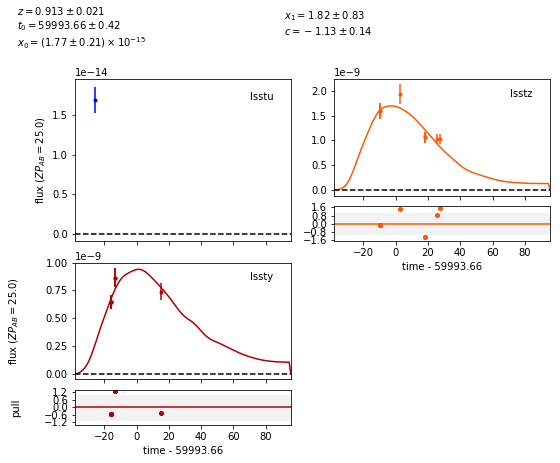

[ 5.57247172e-01  5.99976685e+04  4.54551895e-15 -3.07920031e+00
 -7.48884188e-01]


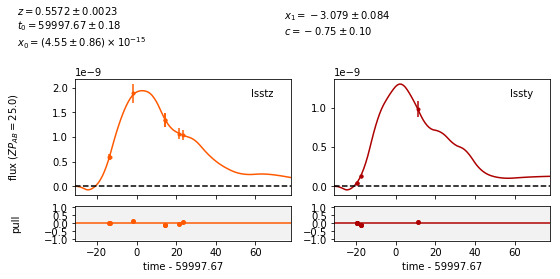

/global/homes/d/djp81/.local/cori/3.6-anaconda-5.2/lib/python3.6/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: lsstr, lsstg, lsstu(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


[ 9.54305105e-01  6.02508502e+04  8.00521955e-16  8.57443934e+00
 -2.80251469e-01]


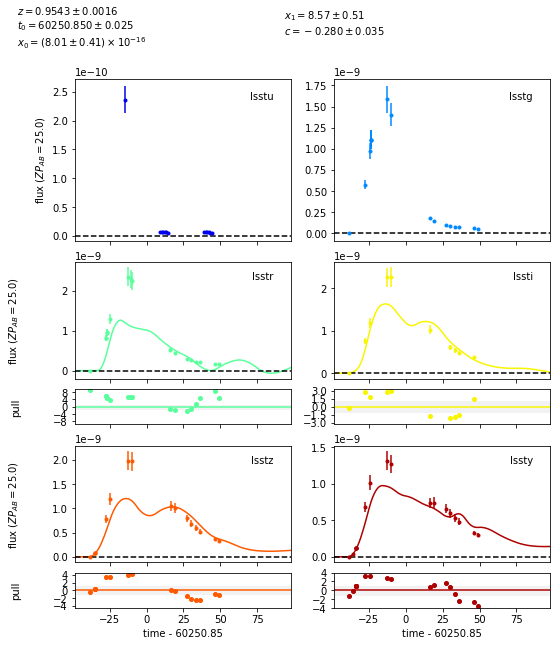

[ 8.93019745e-01  6.02466479e+04  2.50114760e-15 -1.30278726e+00
 -8.41812901e-01]


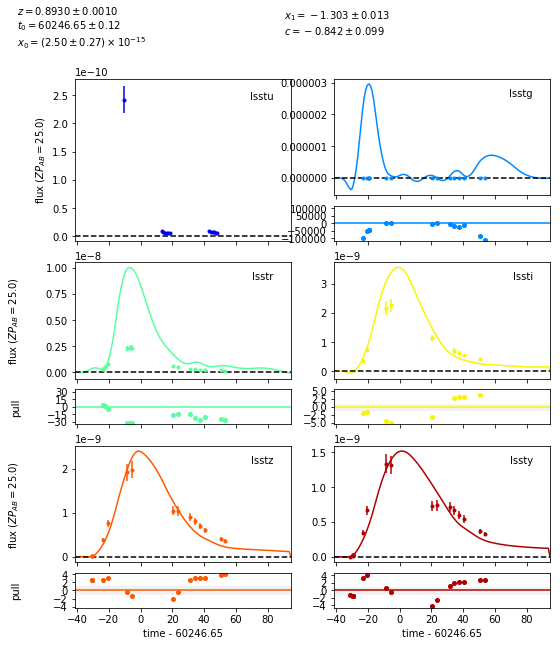

[ 1.08800743e+00  5.98426196e+04  7.90504912e-16  2.36665366e+00
 -7.86000684e-01]


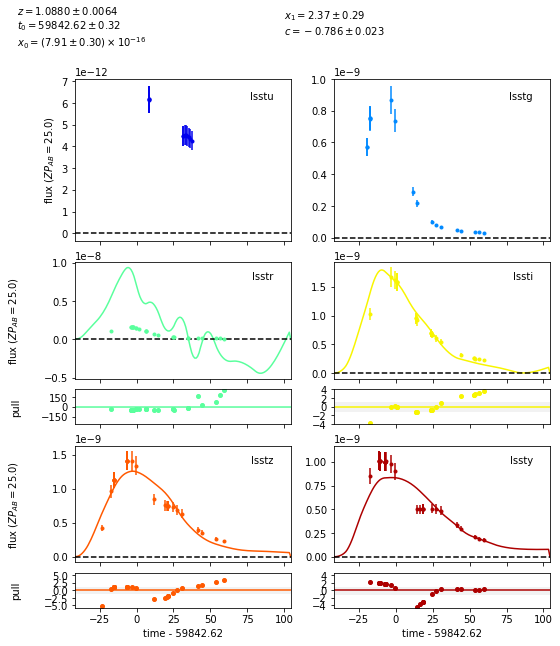

[ 9.47013973e-01  5.98622630e+04  7.60062126e-16  5.57953185e+00
 -3.85986745e-01]


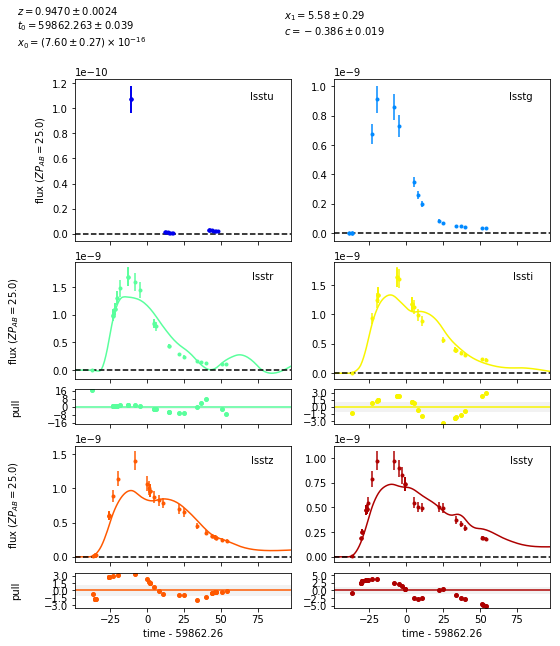

[ 1.30506028e+00  6.01655299e+04  4.99500843e-16  3.05453098e+00
 -5.10208402e-01]


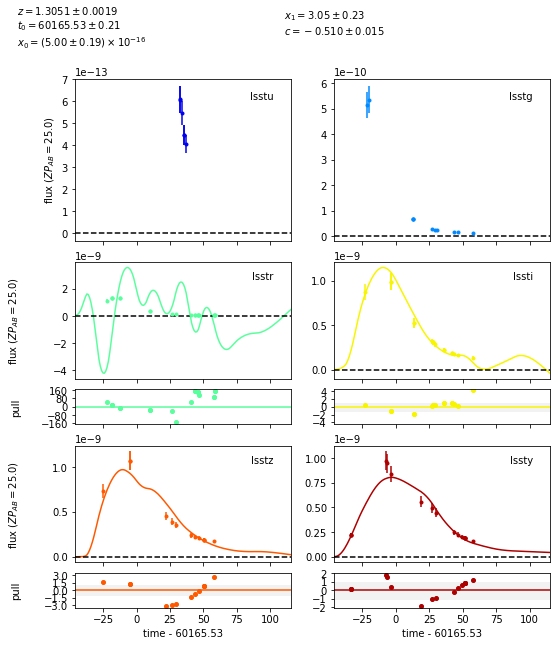

[ 1.29621913e+00  6.01719907e+04  4.85782865e-16  2.45298797e+00
 -5.18851247e-01]


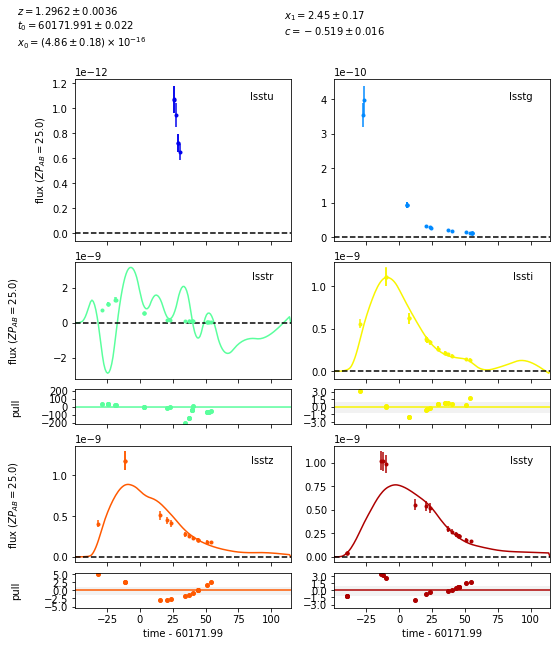

[ 8.74274508e-01  6.02703416e+04  5.62755116e-16  7.70158055e-02
 -3.07296487e-01]


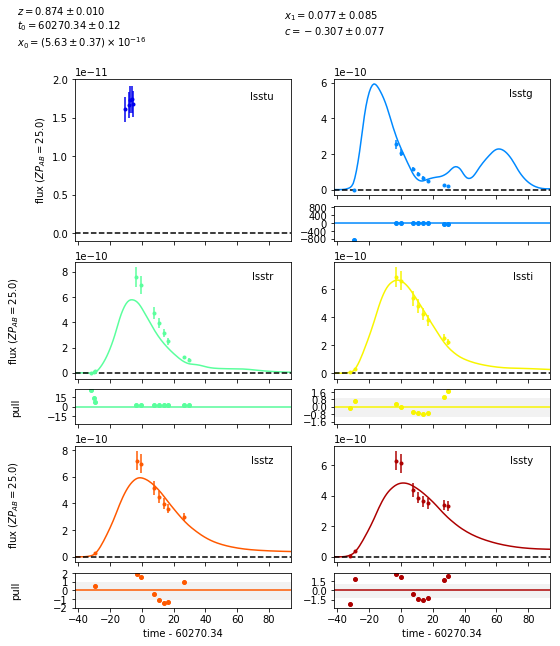

[ 1.21412869e+00  6.02585266e+04  4.31318291e-16  5.49888256e+00
 -5.90885199e-01]


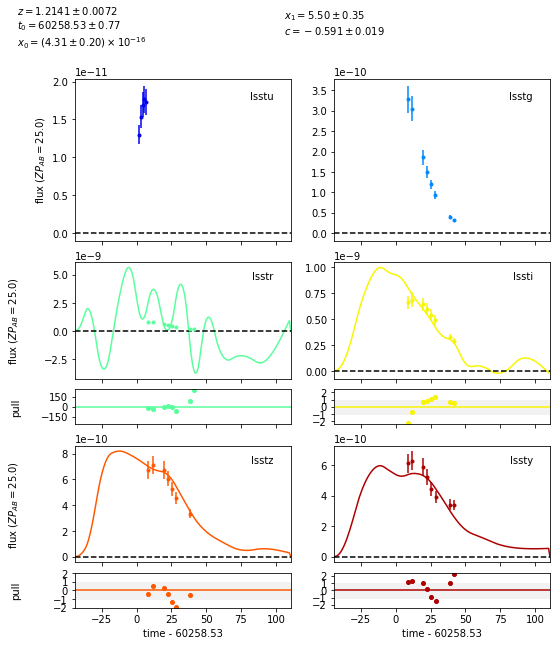

In [10]:
fit_parameters = []
model = sncosmo.Model(source='salt2')
for i, data in enumerate(iter_sncosmo_input(supernovae_ids)):    
    if i == 10:
        break
        
    result, fitted_model = sncosmo.fit_lc(
        data, 
        model,
        ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
        bounds={'z':(0.3, 2)})  # bounds on parameters (if any)
    
    fit_parameters.append(result.parameters)
    sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)
    plt.show()
    

## Fitting With Snoopy

Snoopy requires lightcurves to be specified as a series of input files. We create and fit those files here.

In [ ]:
import sys
home = os.path.expanduser('~')
user_path = os.path.join(home, '.local/cori/3.6-anaconda-5.2/lib/python3.6/site-packages')
sys.path.insert(0, user_path)

import snpy

In [ ]:
def write_snoopy_file(out_path, **kwargs):
    """Creates a snoopy input file out_path/name.txt
    
    Args:
        out_path         (str): Where to write the input file
        name             (str): The name of the target
        redshift       (float): The redshift of the target    
        ra             (float): The ra of the target
        dec            (float): The dec of the target
        <u, g, r, i, z> (dict): The date ('mjd') and magnitude ('mag')
    """
    
    file_text = f'{kwargs["name"]} {kwargs["redshift"]} {kwargs["ra"]} {kwargs["dec"]}\n'
    
    # Todo: Specify LSST filters including y
    band_names = {'u': 'u_s', 
                  'g': 'g_s',
                  'r': 'r_s',
                  'i': 'i_s',
                  'z': 'z_s'}
    
    for band, name in band_names.items():
        if band not in kwargs:
            continue
            
        file_text += f'filter {name}\n'
        
        for mjd, mag in zip(kwargs[band]['mjd'], kwargs[band]['mag']):
            # Todo: Specify the actual error
            file_text += f'{mjd} {mag} {0.01 * mag}\n'
    
    with open(out_path, 'w') as ofile:
        ofile.write(file_text)
    

In [ ]:
def create_snoopy_inputs(out_dir, supernovae):
    """Generate snoopy input files for supernova in the truth catalouge
    
    Args:
        out_dir     (str): The directory to write input files to
        supernovae (dict): Catalog data returned by get_supernovae_data
    
    Returns:
        A list of created file paths
    """

    os.makedirs(out_dir, exist_ok=True)
    meta_table_path = os.path.join(out_dir, 'meta_data.csv')
    return_paths_list = []
    meta_table = Table(names=['target', 'stellat_mass', 'sfr'])
    iter_data = zip(supernovae['ra'], supernovae['dec'], supernovae['uniqueId'], supernovae['galaxy_id'])
    for ra, dec, sn_id, gal_id in iter_data:
        
        # Todo: Specify actual redshift
        redshift = 3 * random()  # truth_static_gc.get_quantities(['redshift'], filters=[f'object_id == {gal_id}'])

        # Truth variable catalog is SQL based so individual queries go by quickly
        u = get_supernova_data(sn_id, 'u')
        g = get_supernova_data(sn_id, 'g')
        r = get_supernova_data(sn_id, 'r')
        i = get_supernova_data(sn_id, 'i')
        z = get_supernova_data(sn_id, 'z')
        y = get_supernova_data(sn_id, 'y')

        # Skip SN with no observations
        bands = (u, g, r, i , z, y)
        if sum((len(x['mjd']) for x in bands)) == 0:
            # print(f'No Observations: {sn_id}\n')  
            continue

        #meta_data = cosmo_gc.get_quantities(['baseDC2/obs_sfr', 'stellar_mass'], filters=[f'galaxy_id == {gal_id}'])
        # meta_table.add_row(... meta_data ...)
        
        out_path = os.path.join(out_dir, f'{sn_id}.txt')
        write_snoopy_file(
            out_path,
            u=u,
            g=g,
            r=r,
            i=i,
            z=z,
            name=sn_id,
            redshift=redshift,
            ra=ra,
            dec=dec
        )
        
        return_paths_list.append(out_path)
    
    return return_paths_list


In [ ]:
# Keep small subset of data for testing
snoopy_supernovae = dict()
for key, array in get_supernovae_ids.items():
    snoopy_supernovae[key] = array[0: 100]

# Generate input files for snoopy
snoopy_dir = './snoopy_data'
snoopy_paths = create_snoopy_inputs(snoopy_dir, snoopy_supernovae)
print(f'{len(snoopy_paths)} input files created')

# Run Snoopy
dist_mod = []
redshift = []
for path in snoopy_paths:
    try:
        s = snpy.get_sn(path)
        s.choose_model('max_model')
        s.fit()
        
    except Error as e :
        print('error', e, file)
        continue
    
    dist_mod.append(s.get_distmod(cosmo='LambdaCDM'))
    with open(path) as f:
        redshift_this = float(f.readline().split(' ')[1])
        redshift.append(redshift_this)

plt.semilogy(z, d_mod, '.')
plt.xlabel('redshift')
plt.ylabel(r'$\nu$')
